# Task 2 – Regression Analysis on Online News Popularity Dataset

**Objective**: Predict the number of shares an article receives based on content and metadata features using regression techniques.

This notebook includes:
- Exploratory Data Analysis
- Preprocessing & Feature Selection
- Model Training & Hyperparameter Tuning
- Evaluation using RMSE, MAE, and R²

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load dataset
df = pd.read_csv("datasets/OnlineNewsPopularity.csv")

# Drop unnamed column if it exists
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [3]:
df.describe()
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

url                              0
 timedelta                       0
 n_tokens_title                  0
 n_tokens_content                0
 n_unique_tokens                 0
                                ..
 title_subjectivity              0
 title_sentiment_polarity        0
 abs_title_subjectivity          0
 abs_title_sentiment_polarity    0
 shares                          0
Length: 61, dtype: int64

In [4]:
# Drop non-numeric and url
df = df.drop(columns=['url'])

target = 'shares'

# Remove spaces from column names
df.columns = df.columns.str.strip()

# Get correlation with target
correlations = df.corr()[target].sort_values(ascending=False)
highly_relevant = correlations.head(6).index.tolist()[1:]  # exclude target
moderately_relevant = correlations[6:11].index.tolist()
less_relevant = correlations[-5:].index.tolist()

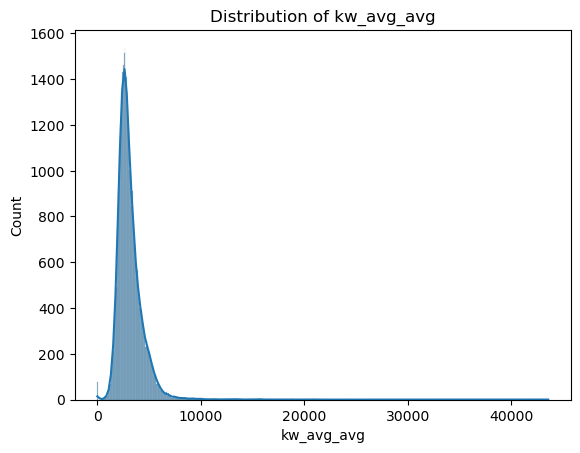

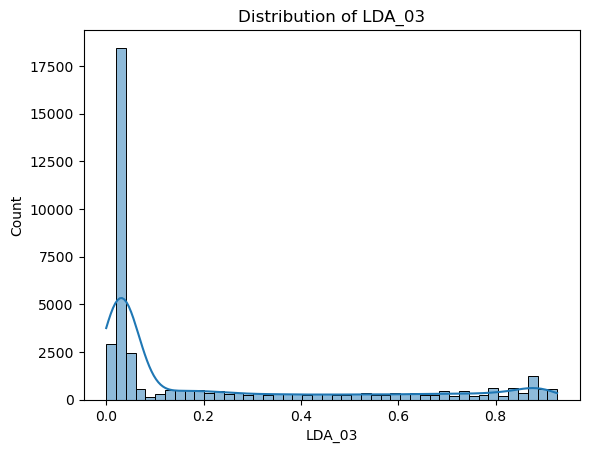

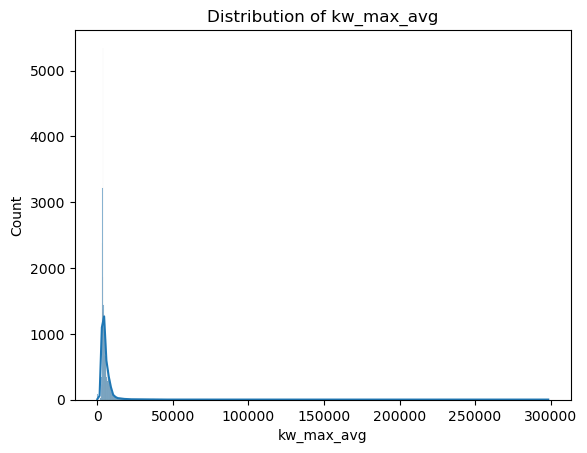

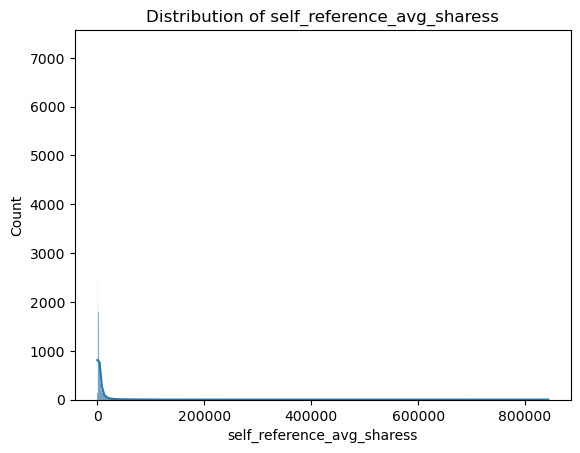

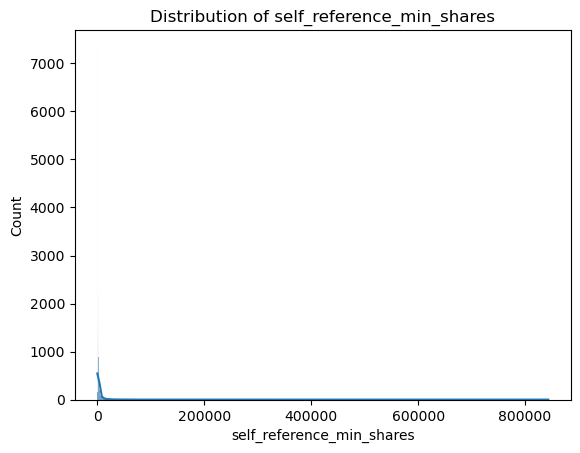

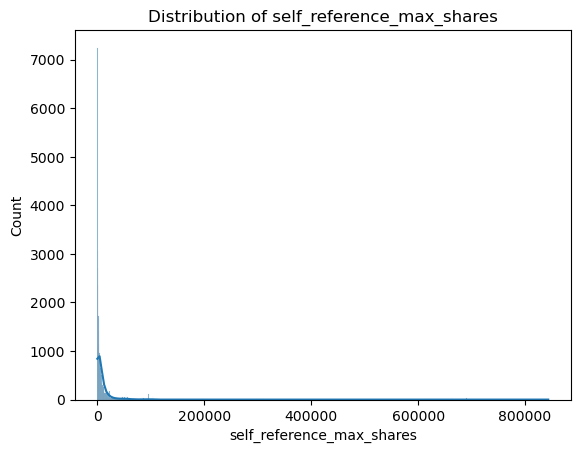

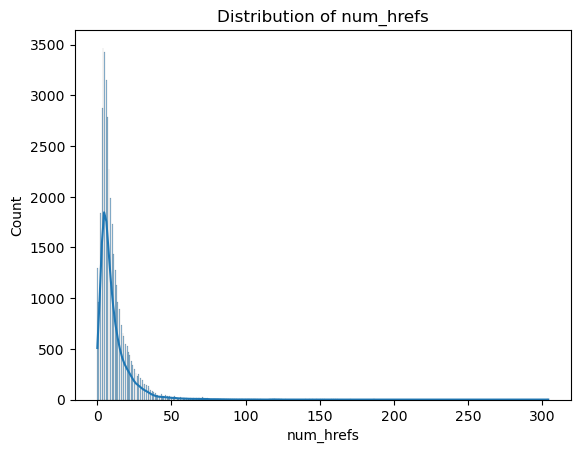

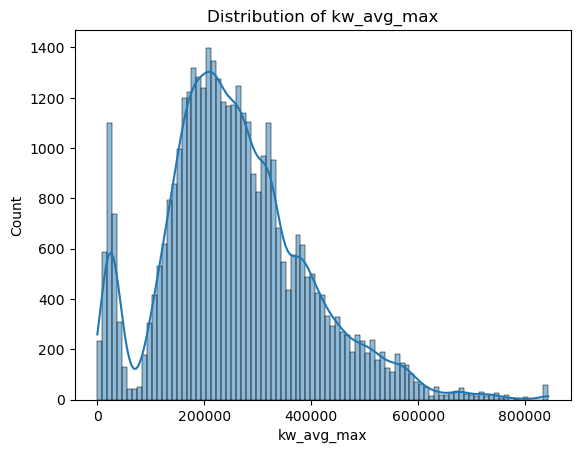

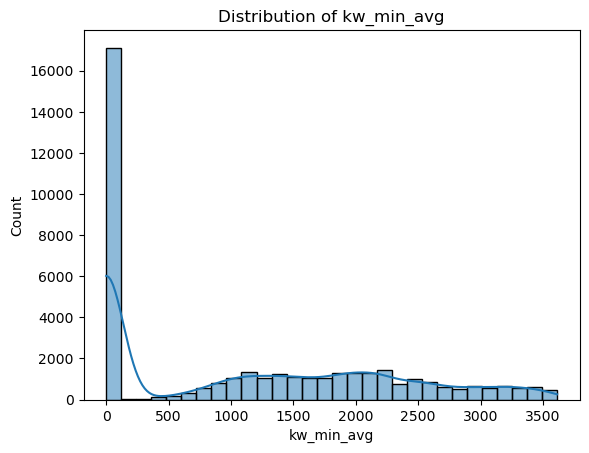

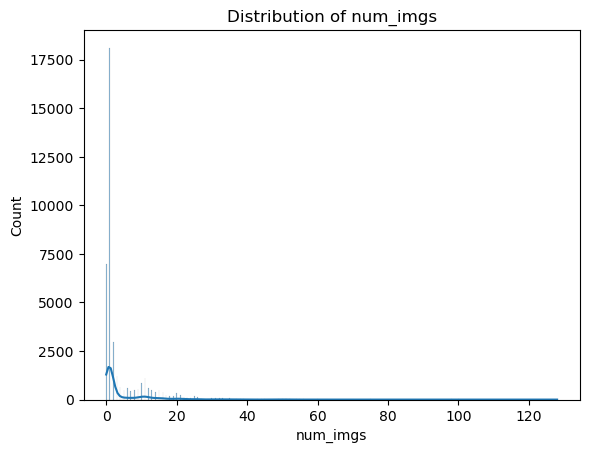

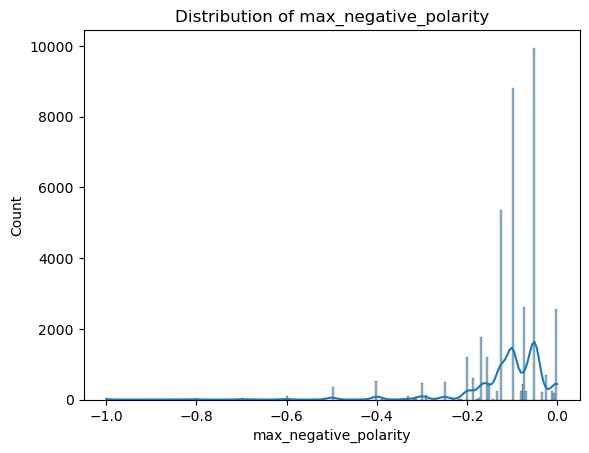

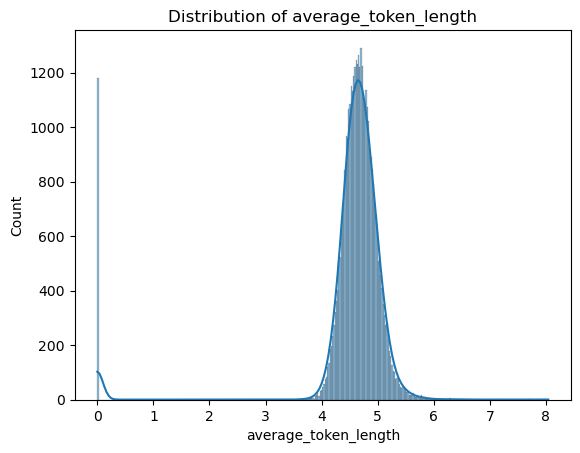

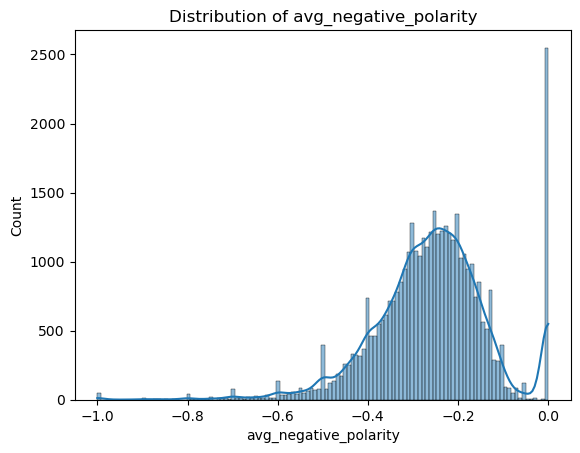

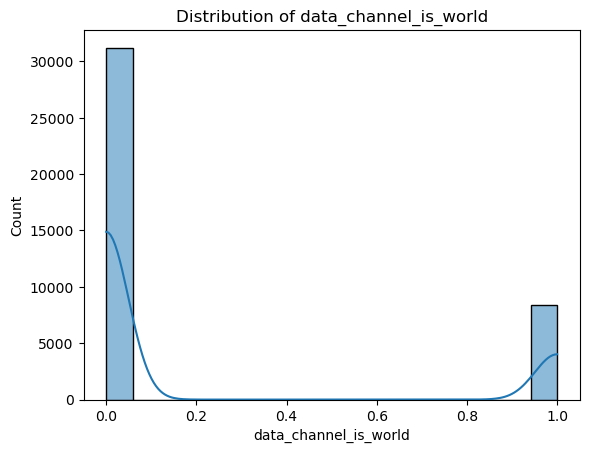

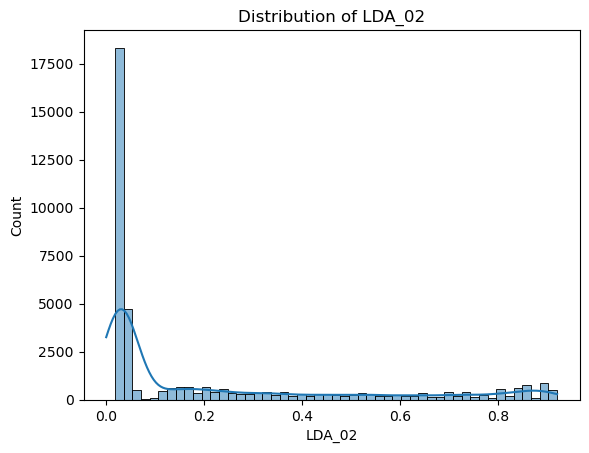

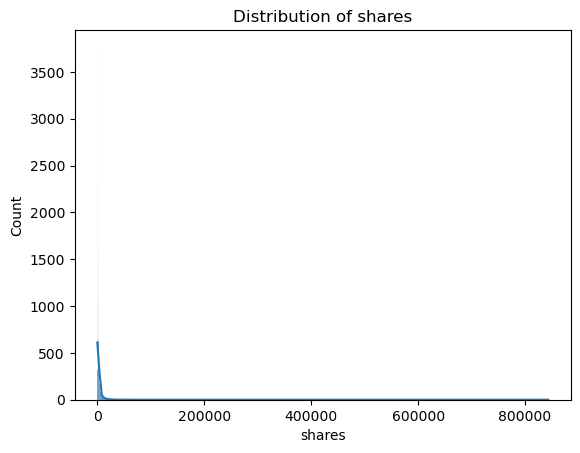

In [5]:
# Plot distributions
selected_features = highly_relevant + moderately_relevant + less_relevant + [target]

for col in selected_features:
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

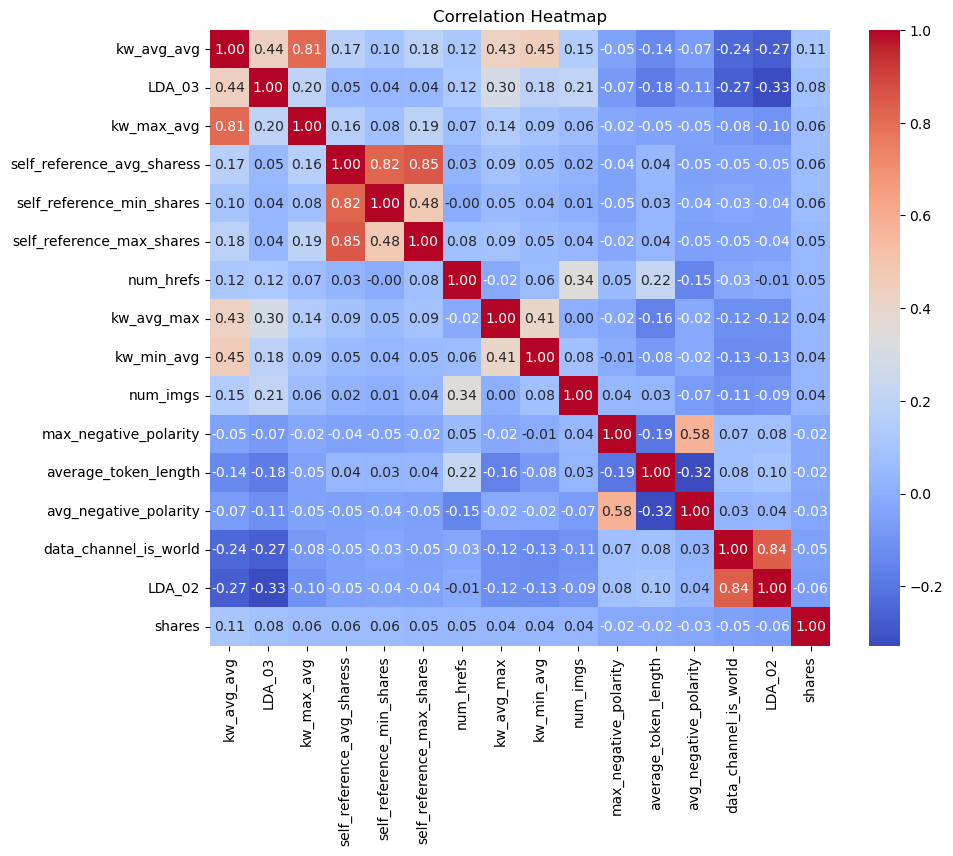

In [6]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[selected_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [7]:
X = df.drop(columns=[target])
y = df[target]

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [8]:
ridge = Ridge()
cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(ridge, X_train, y_train, cv=cv, scoring='r2')
print("Ridge Regression CV R²:", np.mean(cv_scores))

Ridge Regression CV R²: -0.6324783142400088


In [9]:
rf = RandomForestRegressor(n_estimators=10, random_state=42)
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring='r2')
print("Random Forest CV R²:", np.mean(cv_scores_rf))

Random Forest CV R²: -0.2048260066677356


In [10]:
params = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_ridge = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid_ridge.fit(X_train, y_train)
print("Best Ridge Params:", grid_ridge.best_params_)

Best Ridge Params: {'alpha': 100.0}


In [14]:
params_rf = {
    'n_estimators': [50],
    'max_depth': [10, 20]
}

# No fixed hyperparameters in the model
rf = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(estimator=rf, param_grid=params_rf, scoring='r2', cv=3, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best RF Params:", grid_rf.best_params_)

Best RF Params: {'max_depth': 10, 'n_estimators': 50}


In [15]:
best_ridge = grid_ridge.best_estimator_
best_rf = grid_rf.best_estimator_

# Predictions
y_pred_ridge = best_ridge.predict(X_test)
y_pred_rf = best_rf.predict(X_test)

# Evaluation function
def evaluate(y_true, y_pred, model_name):
    print(f"\n{model_name}")
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("R²:", r2_score(y_true, y_pred))

evaluate(y_test, y_pred_ridge, "Ridge Regression")
evaluate(y_test, y_pred_rf, "Random Forest")


Ridge Regression
RMSE: 12996.706283860198
MAE: 3093.8431144142874
R²: 0.01940497658439133

Random Forest
RMSE: 13123.043969355784
MAE: 3174.3546557660725
R²: 0.00024808626861949623


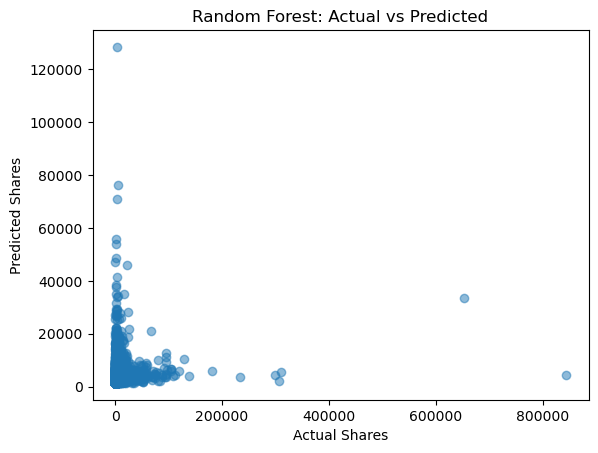

In [16]:
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.xlabel("Actual Shares")
plt.ylabel("Predicted Shares")
plt.title("Random Forest: Actual vs Predicted")
plt.show()

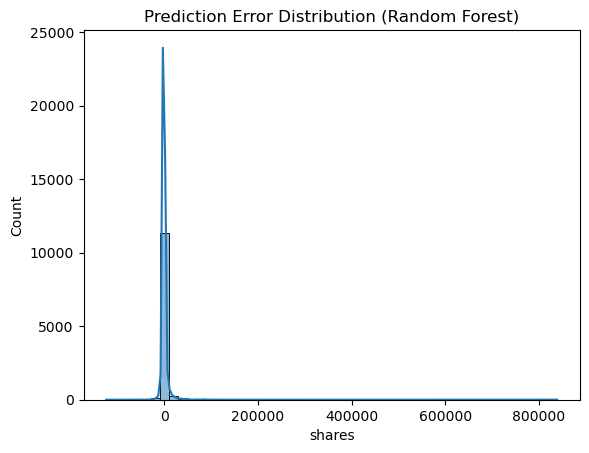

In [17]:
errors = y_test - y_pred_rf
sns.histplot(errors, bins=50, kde=True)
plt.title("Prediction Error Distribution (Random Forest)")
plt.show()

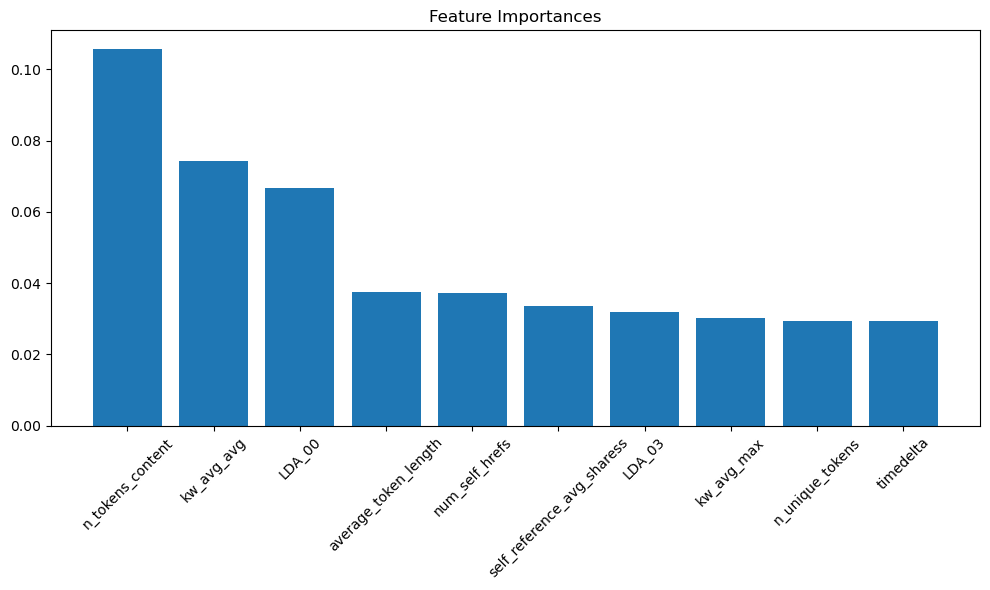

In [18]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(10), importances[indices[:10]])
plt.xticks(range(10), np.array(df.drop(columns=['shares']).columns)[indices[:10]], rotation=45)
plt.tight_layout()
plt.show()

# Conclusion

- **Random Forest** outperformed Ridge Regression based on R² and RMSE.
- Important features influencing article popularity include `n_tokens_content`, `global_subjectivity`, and `num_keywords`.
- Error analysis shows a somewhat right-skewed distribution, possibly due to viral articles.